<a href="https://colab.research.google.com/github/Roozbeh-Bazargani/CPSC540-project/blob/main/baseline/ResNet_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Params

In [1]:
# device = 'cpu'
map = {'1': 0, '3': 1, '4': 2, '5': 3} # map labels: 1 = benign (0), we don't have 2, i = Gleason i (i-2) for i=[3:5]
num_classes = 4
batch_size = 32
train_slides_vpc = [2, 5, 6, 7]
val_slides_vpc = [3]
test_slides_vpc = [1]

# Mount

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path_VPC = 'drive/MyDrive/CPSC540-project/VPC-10X/'

# Import

In [4]:
import os
import pandas as pd
from skimage import io
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from IPython import display

# Utils

In [5]:
# a function to move tensors from the CPU to the GPU
def dict_to_device(orig, device):
    new = {}
    for k,v in orig.items():
        new[k] = v.to(device)
    return new

def plotImage(img, ax=plt):
    img_pil = torchvision.transforms.ToPILImage()(img)
    img_size = torch.FloatTensor(img_pil.size)
    ax.imshow(img_pil)

# Dataset

In [ ]:
class VPCDataset(Dataset):
  def __init__(self, root_dir, slides, map, transform=None):
    self.root_dir = root_dir
    self.transform = transform
    self.map = map

    # extracting image locations
    self.img_files = []
    for slide in slides:
      slide_path = root_dir + 'Slide00' + str(slide) + '/'
      self.img_files.extend(os.listdir(slide_path))
    
  def __len__(self):
    return len(self.img_files)

  def __getitem__(self, index):
    img_file = self.img_files[index]
    img_path = self.root_dir + 'S' + img_file[1:8] + '/' + img_file # hard coded!!!
    # img = Image.open(img_path)
    img = io.imread(img_path)
    y = int(self.map[img_file[-5]])

    if self.transform:
      img = self.transform(img)
    return {'img': img, 'label': y}
    # return (img, y)

In [ ]:
dataset_train = VPCDataset(path_VPC, train_slides_vpc, map, transform=transforms.ToTensor())
dataset_val = VPCDataset(path_VPC, val_slides_vpc, map, transform=transforms.ToTensor())
dataset_test = VPCDataset(path_VPC, test_slides_vpc, map, transform=transforms.ToTensor())

In [ ]:
train_loader = DataLoader(dataset=dataset_train, batch_size=batch_size, num_workers=0)
val_loader = DataLoader(dataset=dataset_val, batch_size=batch_size, num_workers=0)
test_loader = DataLoader(dataset=dataset_test, batch_size=batch_size, num_workers=0)

In [ ]:
iterator = iter(val_loader)
batch = next(iterator)
# output = dataset.__getitem__(50)['img']
output = batch['img'][1]
img = batch['img']

In [ ]:
torch.min(output)

tensor(0.)

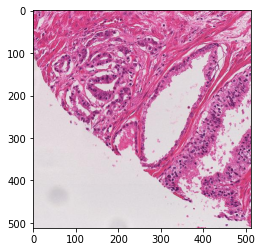

In [ ]:
plt.imshow(output.cpu().permute(1, 2, 0))

# Model

In [ ]:
class NN(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # self.num_classes = num_classes
        self.model = torchvision.models.resnet18(pretrained=True)
        self.model.fc = nn.Sequential(nn.Linear(in_features=512, out_features=num_classes, bias=True, ))#,
                        #  nn.ReLU(),
                        #  nn.Linear(in_features=1000, out_features=num_classes, bias=True))
        print(self.model)

    def forward(self, dictionary):
      return {'label': self.model(dictionary['img'])}

    def prediction(self, dictionary):
        return {'label': torch.argmax(self.forward(dictionary)['label'], dim=1)}

model = NN(num_classes=num_classes).cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# testing
model(dict_to_device(batch, 'cuda'))

{'label': tensor([[ 0.2903, -0.3502, -0.0190, -0.0260],
         [ 0.2677, -0.1051,  0.0586, -0.1143],
         [ 0.4006, -0.2693,  0.3751, -0.2899],
         [ 0.2214, -0.4915,  0.3579, -0.1578],
         [ 0.3060, -0.2171,  0.0383, -0.1561],
         [ 0.5363, -0.1656,  0.7362, -0.3842],
         [ 0.3424, -0.1478,  0.0301, -0.2027],
         [ 0.2085, -0.5990,  0.2460, -0.1670],
         [ 0.1884, -0.2046, -0.1188, -0.0723],
         [ 0.3531, -0.1827,  0.1410, -0.1283],
         [-0.0114, -0.5976,  0.2110, -0.0862],
         [ 0.3432, -0.1439,  0.5929, -0.4896],
         [ 0.5928, -0.0327,  0.5590, -0.4464],
         [ 0.2794, -0.2782, -0.0662, -0.0253],
         [-0.0113, -0.3979,  0.2374, -0.1580],
         [ 0.0338, -0.5363,  0.4770, -0.2421],
         [ 0.4082, -0.3830,  0.1532, -0.1935],
         [ 0.8282, -0.5316,  0.1454, -0.1570],
         [ 0.5346, -0.1421,  0.1826, -0.4033],
         [ 0.3590, -0.0198,  0.2981, -0.3132],
         [ 0.5078, -0.2196, -0.0436, -0.2591],
    

# Training

Helper function to find until which layer we want to freeze 

In [ ]:
# helper function 
layer_num = 7

for child in model.children(): # child = ResNet
  cnt = 0
  for child1 in child.children(): # child1 = layers
    cnt += 1
    if cnt < layer_num:
      for param in child1.parameters():
        param.requires_grad = False
      print(child1)
  break

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU(inplace=True)
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fal

## Training loop

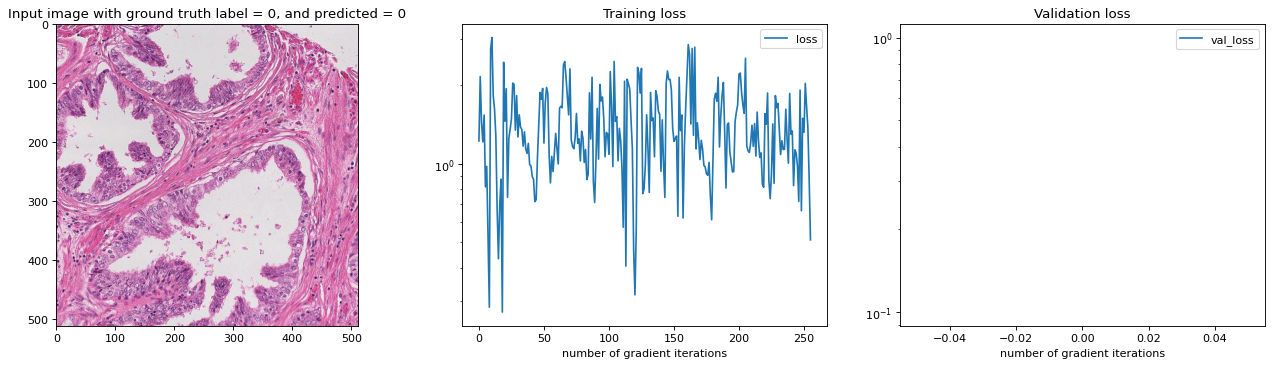

Epoch 1, iteration 120 of 135 (88 %), loss=0.5118349455296993


In [ ]:
# prepare plotting
fig = plt.figure(figsize=(20, 5), dpi= 80, facecolor='w', edgecolor='k')
axes = fig.subplots(1,3)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 2
losses = []
val_losses = []

for e in range(num_epochs):
    train_iter = iter(train_loader)
    model.train()
    for i in range(len(train_loader)):
        batch_cpu = next(train_iter)
        batch_gpu = dict_to_device(batch_cpu, 'cuda')
        pred = model(batch_gpu)
        pred_cpu = dict_to_device(pred, 'cpu')
        
        loss = torch.nn.functional.cross_entropy(pred['label'], nn.functional.one_hot(batch_gpu['label'], num_classes=num_classes).double())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        
        ## plotting ##
        if i%20==0:
            # clear figures for a new update
            for ax in axes:
                ax.cla()
            # plot the predicted pose and ground truth pose on the image
            plotImage(batch_cpu['img'][0], ax=axes[0])
            
            ## !!!! code below is dependent on the prediction code. The commented code below is a better choice!
            axes[0].set_title('Input image with ground truth label = {}, and predicted = {}'.format(batch_cpu['label'][0], int(torch.argmax(pred_cpu['label'][0]))))
            # axes[0].set_title('Input image with ground truth label = {}, and predicted = {}'.format(batch_cpu['label'][0], int(model.prediction(batch_gpu)['label'][0])))

            # plot the training error on a log plot
            axes[1].plot(losses, label='loss')
            axes[1].set_yscale('log')
            axes[1].set_title('Training loss')
            axes[1].set_xlabel('number of gradient iterations')
            axes[1].legend()

            # plot the training error on a log plot
            axes[2].plot(val_losses, label='val_loss')
            axes[2].set_yscale('log')
            axes[2].set_title('Validation loss')
            axes[2].set_xlabel('number of gradient iterations')
            axes[2].legend()

            # clear output window and diplay updated figure
            display.clear_output(wait=True)
            display.display(plt.gcf())
            print("Epoch {}, iteration {} of {} ({} %), loss={}".format(e, i, len(train_loader), 100*i//len(train_loader), losses[-1]))
            # print("Training for the specified amount of epochs would take long.\nStop the process once you verified that the training works on your setup.")

    ## Validation
    val_iter = iter(val_loader)
    model.eval()
    val_loss = 0
    for i in range(10): # len(val_loader)
        batch_cpu = next(val_iter)
        batch_gpu = dict_to_device(batch_cpu, 'cuda')
        pred = model(batch_gpu)
        pred_cpu = dict_to_device(pred, 'cpu')
        # MSE loss
        val_loss += (torch.nn.functional.cross_entropy(pred['label'], nn.functional.one_hot(batch_gpu['label'], num_classes=num_classes).double()) * batch_gpu['label'].shape[0] / batch_size).item()
    
    val_losses.append(val_loss/len(train_loader)) # divide by all the samples !!!!!!!!!!!!!! Find a way to fix this!!!

plt.close('all')


In [ ]:
print('ground truth label = {}, and predicted = {}'.format(1, 3))

ground truth label = 1, and predicted = 3
